<a href="https://www.kaggle.com/code/siddp6/shell-ai-waste-to-energy?scriptVersionId=137954072" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

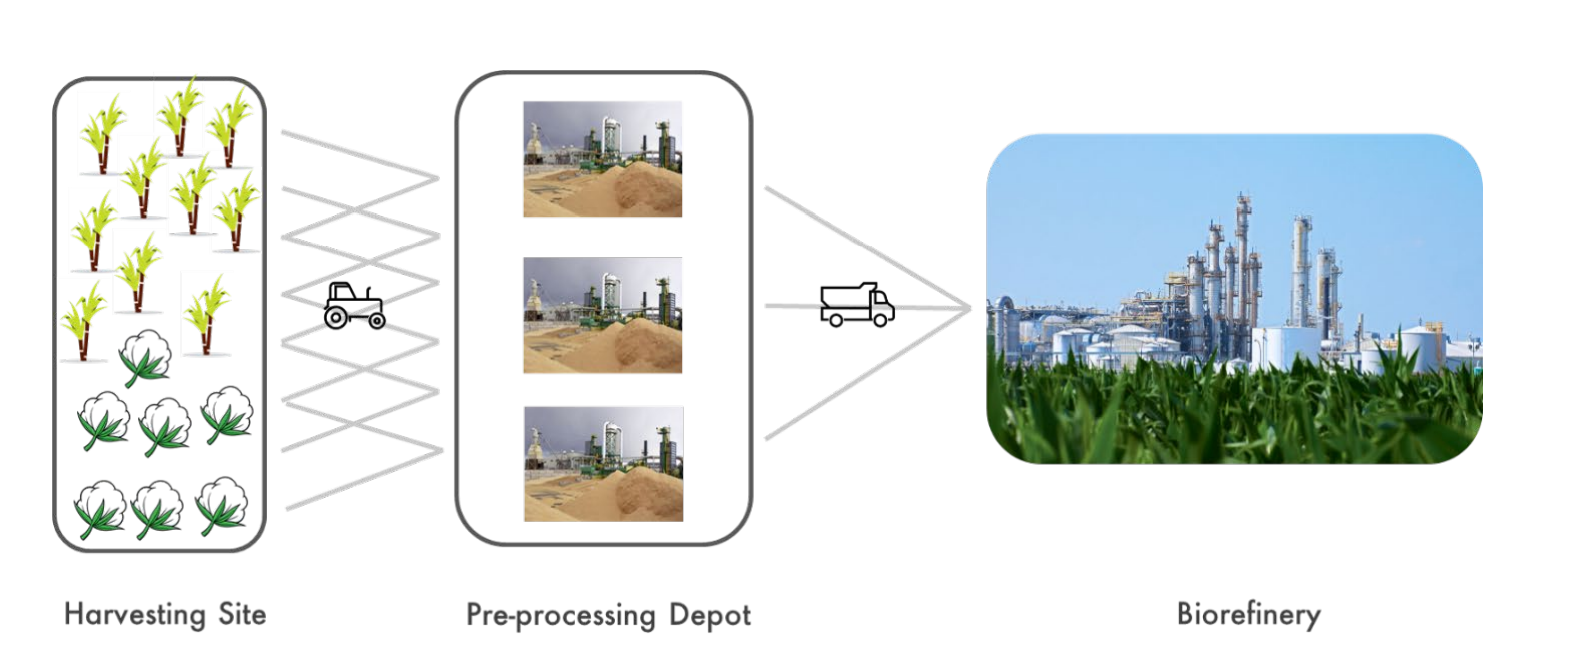

## Step-by-Step Solution

- **Step 0: Import Required Libraries**
  - [X] Import the necessary libraries for data processing, forecasting, optimization, and visualization.

- **Step 1: Data Preprocessing**
  - [X] Load the provided datasets: `Biomass_History.csv` and `Distance_Matrix.csv`.
  - [X] Extract information on biomass availability, distance matrix, and other parameters.
  - [X] Ensure all values are in the correct format and dimensionless.

- **Step 2: Biomass Forecasting for 2018 and 2019**
  - [X] Apply forecasting techniques to estimate biomass availability for the years 2018 and 2019.
  - [X] Create a new datasets, `Biomass_Forecast.csv`, containing forecasted biomass values for each harvesting site.
  - [X] Save the dataset `Biomass_Forecast.csv`


- **Step 3: Define Variables and Constants**
  - [ ] Define the following variables:
    - `Biorefinery`: Binary variable indicating whether a grid block is a biorefinery location.
    - `Depot`: Binary variable indicating whether a grid block is a preprocessing depot location.
    - `Biomass_Demand_Supply[i, j]`: Amount of biomass transported from harvesting site 'i' to depot 'j'.
    - `Pellet_Demand_Supply[j, k]`: Amount of pellets transported from depot 'j' to biorefinery 'k'.
  - [ ] Set constants:
    - `a`, `b`, `c`: Constants for cost computation.
    - `Max_Depots`: Maximum number of preprocessing depots (<= 25).
    - `Max_Refineries`: Maximum number of biorefineries (<= 5).
    - `Max_Depot_Capacity`: Maximum yearly processing capacity of a depot (20,000).
    - `Max_Refinery_Capacity`: Maximum yearly processing capacity of a biorefinery (100,000).

- **Step 4: Formulate the Objective Function**
  - [ ] Define the objective function that minimizes the overall cost of the supply chain.
  - [ ] The objective function should consider transportation costs, biomass forecast mismatch costs, and underutilization costs.

- **Step 5: Formulate the Constraints**
  - [ ] Create constraints to ensure that all quantities are greater than or equal to zero.
  - [ ] Enforce that the amount of biomass procured does not exceed the forecasted biomass at each harvesting site.
  - [ ] Limit the total biomass reaching each preprocessing depot to its yearly processing capacity.
  - [ ] Limit the total pellets reaching each biorefinery to its yearly processing capacity.
  - [ ] Enforce the number of depots to be less than or equal to `Max_Depots`.
  - [ ] Enforce the number of refineries to be less than or equal to `Max_Refineries`.
  - [ ] Ensure that at least 80% of the total forecasted biomass is processed by the refineries each year.
  - [ ] Balance the total biomass entering and exiting each preprocessing depot (within a tolerance limit of 1e-03).

- **Step 6: Optimization**
  - [ ] Utilize appropriate optimization techniques (e.g., mathematical programming, linear programming) to solve the formulated problem.
  - [ ] Find the optimal locations for preprocessing depots and biorefineries.
  - [ ] Allocate biomass quantities and pellets to minimize the objective function while satisfying all constraints.

- **Step 7: Post-processing and Visualization**
  - [ ] Analyze the optimized supply chain to visualize the optimal locations of depots and refineries on the map of Gujarat.
  - [ ] Display the transportation routes for biomass and pellets between harvesting sites, depots, and refineries.
  - [ ] Summarize the total cost and other relevant information about the optimized supply chain.

- **Step 8: Output Submission**
  - [ ] Generate the final output file (`solution.csv`) in the required format with columns for year, data type, source index, destination index, and corresponding values.
  - [ ] Submit the solution file on the HackerEarth portal for evaluation.


# Step 0: Import Required Libraries

In [1]:
!pip install pandas numpy matplotlib pulp

In [2]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pulp import LpProblem, LpVariable, LpMaximize, LpMinimize, lpSum

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
warnings.filterwarnings("ignore")

#  Step 1: Data Preparation and Exploration


In [4]:
# Load the datasets
biomass_history_df = pd.read_csv('/kaggle/input/biomasshistory/dataset/Biomass_History.csv')
distance_matrix_df = pd.read_csv('/kaggle/input/biomasshistory/dataset/Distance_Matrix.csv')

In [5]:
# Check for any missing values in the datasets
print("\nMissing Values in Biomass History Data:")
print(biomass_history_df.isnull().sum())

print("\nMissing Values in Distance Matrix Data:")
print(distance_matrix_df.isnull().sum())


Missing Values in Biomass History Data:
Index        0
Latitude     0
Longitude    0
2010         0
2011         0
2012         0
2013         0
2014         0
2015         0
2016         0
2017         0
dtype: int64

Missing Values in Distance Matrix Data:
Unnamed: 0    0
0             0
1             0
2             0
3             0
             ..
2413          0
2414          0
2415          0
2416          0
2417          0
Length: 2419, dtype: int64


In [6]:
# Display the first few rows of each dataset to inspect the data
print("Biomass History Data:")
print(biomass_history_df.head())

print("\nDistance Matrix Data:")
print(distance_matrix_df.head())

Biomass History Data:
   Index  Latitude  Longitude       2010       2011       2012       2013  \
0      0  24.66818   71.33144   8.475744   8.868568   9.202181   6.023070   
1      1  24.66818   71.41106  24.029778  28.551348  25.866415  21.634459   
2      2  24.66818   71.49069  44.831635  66.111168  56.982258  53.003735   
3      3  24.66818   71.57031  59.974419  80.821304  78.956543  63.160561   
4      4  24.66818   71.64994  14.653370  19.327524  21.928144  17.899586   

        2014       2015       2016        2017  
0  10.788374   6.647325   7.387925    5.180296  
1  34.419411  27.361908  40.431847   42.126945  
2  70.917908  42.517117  59.181629   73.203232  
3  93.513924  70.203171  74.536720  101.067352  
4  19.534035  19.165791  16.531315   26.086885  

Distance Matrix Data:
   Unnamed: 0        0        1        2        3        4        5        6  \
0           0   0.0000  11.3769  20.4557  38.1227  45.3810  54.9915  78.6108   
1           1  11.3769   0.0000   9.07

In [7]:
# Display the data type
print("Biomass History Info:")
print(biomass_history_df.info())

print("\nDistance Matrix Info:")
print(distance_matrix_df.info())

Biomass History Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418 entries, 0 to 2417
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Index      2418 non-null   int64  
 1   Latitude   2418 non-null   float64
 2   Longitude  2418 non-null   float64
 3   2010       2418 non-null   float64
 4   2011       2418 non-null   float64
 5   2012       2418 non-null   float64
 6   2013       2418 non-null   float64
 7   2014       2418 non-null   float64
 8   2015       2418 non-null   float64
 9   2016       2418 non-null   float64
 10  2017       2418 non-null   float64
dtypes: float64(10), int64(1)
memory usage: 207.9 KB
None

Distance Matrix Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418 entries, 0 to 2417
Columns: 2419 entries, Unnamed: 0 to 2417
dtypes: float64(2418), int64(1)
memory usage: 44.6 MB
None


# Step:2 Biomass Forecasting (Time Series Forecasting)

In [ ]:
# Prepare the data for ARIMA model
biomass_availability = biomass_history_df.iloc[:, 3:].values

# Define the number of time periods (years) for forecasting (2010 to 2017)
num_periods = biomass_availability.shape[1]

# Initialize the forecast array for 2018 and 2019
biomass_forecast_2018 = np.zeros(biomass_availability.shape[0])
biomass_forecast_2019 = np.zeros(biomass_availability.shape[0])


# Loop through each harvesting site and forecast biomass availability for 2018
for i in range(biomass_availability.shape[0]):
    # Fit ARIMA model for each harvesting site
    model = ARIMA(biomass_availability[i, :], order=(1, 1, 0))  # (p, d, q) order
    model_fit = model.fit()
    
    # Forecast biomass availability for 2018 and 2019 (one step ahead forecast)
    forecast_2018 = model_fit.forecast(steps=1)
    forecast_2019 = model_fit.forecast(steps=2)  # Forecast for 2018 and 2019
    
    biomass_forecast_2018[i] = forecast_2018[0]
    biomass_forecast_2019[i] = forecast_2019[1]

In [ ]:
# Display the forecasted biomass for 2018 and 2019 for all harvesting sites
print("Forecasted Biomass for 2018:")
print(biomass_forecast_2018)
print("Forecasted Biomass for 2019:")
print(biomass_forecast_2019)

In [ ]:
# Create a new DataFrame for the forecasted biomass data
biomass_forecast_df = biomass_history_df.copy()

# Add the forecasted biomass for 2018 to the new DataFrame
biomass_forecast_df['2018'] = biomass_forecast_2018
biomass_forecast_df['2019'] = biomass_forecast_2019

# Display the new DataFrame
print(biomass_forecast_df.head())

# Save the new DataFrame as a new CSV file
biomass_forecast_df.to_csv('Biomass_Forecast_Data.csv', index=False)

# Step 3: Define Variables and Constants



In [8]:
# Load the forecast dataset containing historical data and the forecasts for 2018 and 2019
forecast_dataset = pd.read_csv('/kaggle/working/Biomass_Forecast_Data.csv')
print(forecast_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2418 entries, 0 to 2417
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Index      2418 non-null   int64  
 1   Latitude   2418 non-null   float64
 2   Longitude  2418 non-null   float64
 3   2010       2418 non-null   float64
 4   2011       2418 non-null   float64
 5   2012       2418 non-null   float64
 6   2013       2418 non-null   float64
 7   2014       2418 non-null   float64
 8   2015       2418 non-null   float64
 9   2016       2418 non-null   float64
 10  2017       2418 non-null   float64
 11  2018       2418 non-null   float64
 12  2019       2418 non-null   float64
dtypes: float64(12), int64(1)
memory usage: 245.7 KB
None


In [9]:
# Define the biomass demand-supply matrix and pellet demand-supply matrix for each site and depot/refinery
num_harvesting_sites = len(forecast_dataset)
num_depots = 25
num_refineries = 5

print(num_harvesting_sites, num_depots, num_refineries) # 2418 25 5

2418 25 5


In [10]:
# Create the linear programming problem
prob = LpProblem("Biomass_Supply_Chain", LpMinimize)

In [11]:
# Decision variables: biomass[i][j] represents biomass quantity transported from site i to depot j
biomass = []
for i in range(num_harvesting_sites):
    biomass_row = []
    for j in range(num_depots):
        biomass_row.append(LpVariable(f'Biomass_{i}_{j}', lowBound=0))
    biomass.append(biomass_row)

# Decision variables: pellets[j][k] represents pellet quantity transported from depot j to refinery k
pellets = []
for j in range(num_depots):
    pellets_row = []
    for k in range(num_refineries):
        pellets_row.append(LpVariable(f'Pellets_{j}_{k}', lowBound=0))
    pellets.append(pellets_row)

In [12]:
# Define the cost coefficients for biomass transportation from sites to depots and pellets transportation from depots to refineries
cost_biomass_transport = distance_matrix_df.values  
cost_pellet_transport = distance_matrix_df.values 

In [13]:
# Set the objective function
prob += lpSum(biomass[i][j] * cost_biomass_transport[i][j] for i in range(num_harvesting_sites) for j in range(num_depots)) + \
        lpSum(pellets[j][k] * cost_pellet_transport[j][k] for j in range(num_depots) for k in range(num_refineries))

In [14]:
# Constraint 1: Biomass transportation from harvesting sites to depots must be less than or equal to forecasted biomass
for i in range(num_harvesting_sites):
    prob += lpSum(biomass[i][j] for j in range(num_depots)) <= forecast_dataset.iloc[i][-1]

# Constraint 2: Total biomass reaching each depot must be less than or equal to its yearly processing capacity
max_depot_capacity = 20000
for j in range(num_depots):
    prob += lpSum(biomass[i][j] for i in range(num_harvesting_sites)) <= max_depot_capacity

# Constraint 3: Total pellets reaching each refinery must be less than or equal to its yearly processing capacity
max_refinery_capacity = 100000
for k in range(num_refineries):
    prob += lpSum(pellets[j][k] for j in range(num_depots)) <= max_refinery_capacity

# Constraint 4: At least 80% of the total forecasted biomass must be processed by refineries each year
total_forecasted_biomass = forecast_dataset.iloc[:, -1].sum()
total_processed_biomass = lpSum(pellets[j][k] for j in range(num_depots) for k in range(num_refineries))
prob += total_processed_biomass >= 0.8 * total_forecasted_biomass

# Constraint 5: Total biomass entering each preprocessing depot must be equal to the total pellets exiting that depot
for j in range(num_depots):
    prob += lpSum(biomass[i][j] for i in range(num_harvesting_sites)) == lpSum(pellets[j][k] for k in range(num_refineries))

# Constraint 6: Number of depots should be less than or equal to 25
num_depots_constraint = 25
prob += lpSum(pellets[j][k] for j in range(num_depots) for k in range(num_refineries)) == num_depots_constraint

# Constraint 7: Number of refineries should be less than or equal to 5
num_refineries_constraint = 5
prob += lpSum(pellets[j][k] for j in range(num_depots) for k in range(num_refineries)) == num_refineries_constraint

In [15]:
# Solve the linear programming problem
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.10/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8cdbb065d418491e852a245b3d081c1a-pulp.mps timeMode elapsed branch printingOptions all solution /tmp/8cdbb065d418491e852a245b3d081c1a-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 2481 COLUMNS
At line 245002 RHS
At line 247479 BOUNDS
At line 247480 ENDATA
Problem MODEL has 2476 rows, 60575 columns and 181975 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Presolve determined that the problem was infeasible with tolerance of 1e-08
Analysis indicates model infeasible or unbounded
1 infeasibilities
Analysis indicates model infeasible or unbounded
0  Obj 0 Primal inf 287941.17 (3)
2  Obj 2.8791117e-13 Primal inf 1051614.7 (4)
Primal infeasible - objective value 2.8791117e-13
PrimalInfeasible objective 2.879111739e-13 - 2 iterations time 0.032

Res

-1

In [16]:
# Display the optimized results
print("Optimal Biomass Transportation:")
for i in range(num_harvesting_sites):
    for j in range(num_depots):
        print(f"Biomass_{i}_{j}: {biomass[i][j].varValue}")
print("Optimal Pellet Transportation:")
for j in range(num_depots):
    for k in range(num_refineries):
        print(f"Pellets_{j}_{k}: {pellets[j][k].varValue}")

Optimal Biomass Transportation:
Biomass_0_0: 0.0
Biomass_0_1: 0.0
Biomass_0_2: 0.0
Biomass_0_3: 0.0
Biomass_0_4: 0.0
Biomass_0_5: 0.0
Biomass_0_6: 0.0
Biomass_0_7: 0.0
Biomass_0_8: 0.0
Biomass_0_9: 0.0
Biomass_0_10: 0.0
Biomass_0_11: 0.0
Biomass_0_12: 0.0
Biomass_0_13: 0.0
Biomass_0_14: 0.0
Biomass_0_15: 0.0
Biomass_0_16: 0.0
Biomass_0_17: 0.0
Biomass_0_18: 0.0
Biomass_0_19: 0.0
Biomass_0_20: 0.0
Biomass_0_21: 0.0
Biomass_0_22: 0.0
Biomass_0_23: 0.0
Biomass_0_24: 0.0
Biomass_1_0: 0.0
Biomass_1_1: 0.0
Biomass_1_2: 0.0
Biomass_1_3: 0.0
Biomass_1_4: 0.0
Biomass_1_5: 0.0
Biomass_1_6: 0.0
Biomass_1_7: 0.0
Biomass_1_8: 0.0
Biomass_1_9: 0.0
Biomass_1_10: 0.0
Biomass_1_11: 0.0
Biomass_1_12: 0.0
Biomass_1_13: 0.0
Biomass_1_14: 0.0
Biomass_1_15: 0.0
Biomass_1_16: 0.0
Biomass_1_17: 0.0
Biomass_1_18: 0.0
Biomass_1_19: 0.0
Biomass_1_20: 0.0
Biomass_1_21: 0.0
Biomass_1_22: 0.0
Biomass_1_23: 0.0
Biomass_1_24: 0.0
Biomass_2_0: 0.0
Biomass_2_1: 0.0
Biomass_2_2: 0.0
Biomass_2_3: 0.0
Biomass_2_4: 0.0
Bio

In [17]:
# Optionally, save the optimized results in a CSV file
optimized_results = pd.DataFrame(index=range(num_harvesting_sites), columns=['Harvesting Site', 'Depot', 'Biomass Transportation', 'Pellet Transportation'])
for i in range(num_harvesting_sites):
    for j in range(num_depots):
        optimized_results.loc[i, 'Harvesting Site'] = i
        optimized_results.loc[i, 'Depot'] = j
        optimized_results.loc[i, 'Biomass Transportation'] = biomass[i][j].varValue
for j in range(num_depots):
    for k in range(num_refineries):
        optimized_results.loc[j*num_refineries + k, 'Pellet Transportation'] = pellets[j][k].varValue
optimized_results.to_csv('Optimized_Supply_Chain.csv', index=False)